In [1]:
import numpy as np 
import pandas as pd
import os
import re
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

SEED = 7

print("Setup complete.")

Setup complete.


# Feature engineering

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
datasets = [train, test]

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here, we check each and every feature.

Running the following commands, we see there are 12 columns in the training data, 3 of which having NaN -- "Age", "Cabin" and "Embarked". Also, the 3 columns of "Age", "Fare" and "Cabin" in the test dataset include missing values. We'll take care of these columns later.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The features are listed as above.

### 0. PassengerId
This column includes IDs and doesn't affrect the survival.

### 1. Survived
This is the target column.

### 2. Pclass

This is the ticket class, with the numeric values 1=1st, 2=2nd, 3=3rd and no NaN.

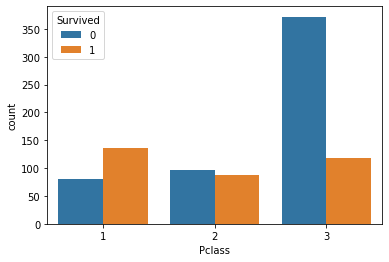

In [5]:
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.show() # To remove extra message shown on screen

### 3. Name
Each name in the dataset is associated with a title. Instead of 'Name' that is observed once, probably, for each passenger, we can use a common feature, title, to group passengers.

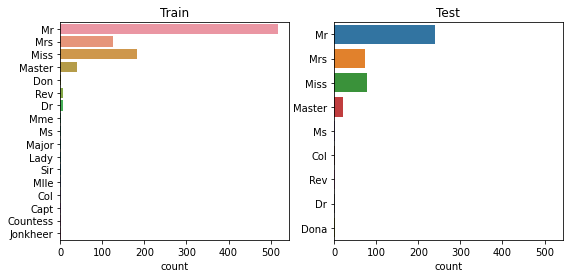

In [6]:
def get_title(name):
    reg_exp = re.search(' ([A-Za-z]+)\.', name)
    return reg_exp.group(1) if reg_exp else ""

# Number of different titles
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

sns.countplot(data=train, y=train['Name'].apply(get_title), ax=ax[0])
ax[0].set(title='Train', ylabel='')

sns.countplot(data=test, y=test['Name'].apply(get_title), ax=ax[1])
ax[1].set(title='Test', ylabel='')
plt.show()

Some titles can be replaced by another one, e.g. 'Mlle'=Mademoiselle (French) with 'Miss'. Also, most titles are rare, e.g. 'Col' that is used only for 2 passengers, so it'd be helpful to replace them with 'Rare'.

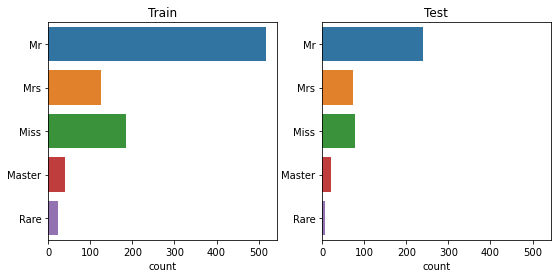

In [7]:
for ds in datasets:
    # Add Title column
    ds['Title'] = ds['Name'].apply(get_title)
    # Replacement
    ds['Title'] = \
        ds['Title'].replace(['Mlle', 'Ms'], 'Miss').replace('Mme', 'Mrs')
    rare = ['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 
            'Lady', 'Major', 'Rev', 'Sir']
    ds['Title'] = ds['Title'].replace(rare, 'Rare')

# Number of different titles
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

sns.countplot(data=train, y='Title', ax=ax[0])
ax[0].set(title='Train', ylabel='')

sns.countplot(data=test, y='Title', ax=ax[1])
ax[1].set(title='Test', ylabel='')
plt.show()

### 4. Sex
There is no NaN in this column.

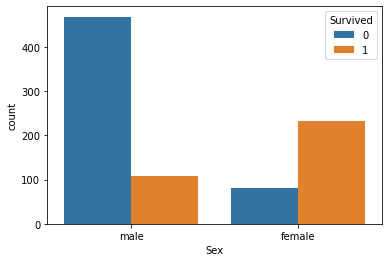

In [8]:
sns.countplot(data=train, x='Sex', hue='Survived')
plt.show()

### 5. Age
In this column, there is plenty of missing values. To impute, we can use random numbers in the range of mean - std ($\mu - \sigma$) and mean + std ($\mu + \sigma$). Statistically speaking, 68% of data is in this range.

Then, we categorise "Age" into 4 categories of <= 14 years (children), (14, 24] years (youth), (24, 64] years (adults) and > 64 years (seniors).

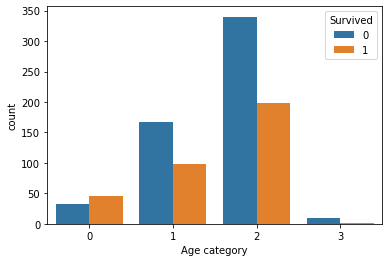

In [9]:
for ds in datasets:
    # Imputate (fill missing values)
    def rand_ages():
        np.random.seed(SEED)
        return np.random.randint(low=ds['Age'].mean() - ds['Age'].std(),
                                 high=ds['Age'].mean() + ds['Age'].std(),
                                 size=ds['Age'].isnull().sum())
    ds.loc[ds['Age'].isnull(), 'Age'] = rand_ages()

    # Categorise
    ds['Age'] = pd.cut(
        ds['Age'], bins=[-np.inf, 14, 24, 64, np.inf], labels=range(4))
    ds.loc[:, 'Age'] = ds['Age'].astype(int)
    
# Plot
ax = sns.countplot(data=train, x='Age', hue='Survived')
ax.set_xlabel('Age category')
plt.show()

### 6. SibSp
This is the number of siblings/spouses aboard the Titanic and can be considered along with "Parch" feature.

### 7. Parch
This is the number of parents/children. We can consider it along with "SibSp" to make a new feature, "FamilySize", that can be categorized into 
 4 categories comprising 1, 2, {3, 4} and >= 5 members.

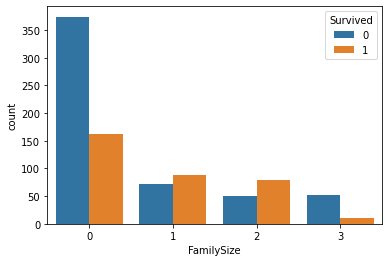

In [10]:
for ds in datasets:
    # Family size is based on number of siblings/spouses and parent/children
    family_size = ds['SibSp'] + ds['Parch'] + 1
    
    # Categorise
    ds['FamilySize'] = pd.cut(
        family_size, bins=[-np.inf, 1, 2, 4, np.inf], labels=range(4))
    ds.loc[:, 'FamilySize'] = ds['FamilySize'].astype(int)

# Plot
sns.countplot(data=train, x='FamilySize', hue='Survived')
plt.show()

### 8. Ticket
The ticket number doesn't affect the survival.

### 9. Fare
To impute, we use median of training data. Then, we categorise it into 4 categories.

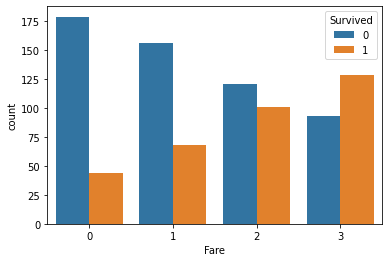

In [11]:
median = train['Fare'].median()
for ds in datasets:
    #Impute
    ds['Fare'] = ds['Fare'].fillna(median)
    
    # Categorise
    ds['Fare'] = pd.qcut(ds['Fare'], q=4, labels=range(4))
    ds.loc[:, 'Fare'] = ds['Fare'].astype(int)

# Plot
sns.countplot(data=train, x='Fare', hue='Survived')
plt.show()

It's seen that the more the fare, the more the number of survived passengers.

### 10. Cabin
Most values of this column are NaN, meaning that most passengers didn't have cabins. We add a feature to show if a passenger had cabin or not.

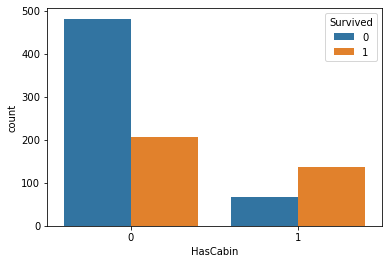

In [12]:
for ds in datasets:
    ds['HasCabin'] = ds['Cabin'].notnull().astype(int)

# Plot
sns.countplot(data=train, x='HasCabin', hue='Survived')
plt.show()

### 11. Embarked
This column has missing values. We impute them by the most frequent value.

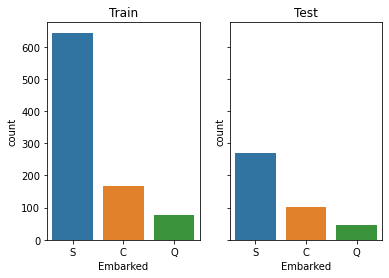

In [13]:
# Count of values
fig, ax = plt.subplots(1, 2, sharey=True)

sns.countplot(data=train, x='Embarked', ax=ax[0])
ax[0].set_title('Train')

sns.countplot(data=test, x='Embarked', ax=ax[1], order=['S', 'C', 'Q'])
ax[1].set_title('Test')
plt.show()

We see that "S" is the most frequent port of embarkation.

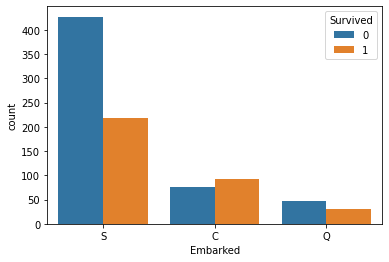

In [14]:
# Impute
for ds in datasets:
    ds['Embarked'] = ds['Embarked'].fillna('S')

# Plot
sns.countplot(data=train, x='Embarked', hue='Survived')
plt.show()

# Data encoding
Looking into the datasets, there are categorical features, that need to be converted to numberical ones in order for modelling. This is called "encoding".

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0,NaN,S,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,PC 17599,3,C85,C,Mrs,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,2,0,0,STON/O2. 3101282,1,NaN,S,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,113803,3,C123,S,Mrs,1,1
4,5,0,3,"Allen, Mr. William Henry",male,2,0,0,373450,1,NaN,S,Mr,0,0


In [16]:
train.shape

(891, 15)

Here, we encode features based on frequency of occurance of their values, i.e. the most frequent value in each feature is encoded to 0, the second most frequent to 1 and so on.

In [17]:
# Encoding
def encode_freq_sorted(feature):
    sorted_indices = feature.value_counts().index
    sorted_dict = dict(zip(sorted_indices, range(len(sorted_indices))))
    return feature.map(sorted_dict).astype(int)
    
for ds in datasets:
    ds['Sex'] = encode_freq_sorted(ds['Sex']) # Sex
    ds['Embarked'] = encode_freq_sorted(ds['Embarked']) # Embarked
    ds['Title'] = encode_freq_sorted(ds['Title']) # Title

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,NaN,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3,C85,1,2,1,1
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1,NaN,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,3,C123,0,2,1,1
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,1,NaN,0,0,0,0


Note that if we didn't care about the frequency of values, we could use "sklearn.preprocessing.LabelEncoder". At the moment, that library doesn't support arbitrary ordering of values of the features.

# Feature selection
At this step, we drop the features that wouldn't affect (much) the target.

In [18]:
drop_features = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']

This is because we used 
* "Name" -> "Title", 
* "SibSp" and "Parch" -> "FamilySize", 
* "Ticket" -> drop,
* "Cabin" -> "HasCabin".

To explore the data, we can visualize the correlation between features. The correlation coefficient shows the linear relation between features. Strong correlation between two features, which is shown by values close to +1 or -1, means there is redundancy in data, therefore one of the features can be dropped.

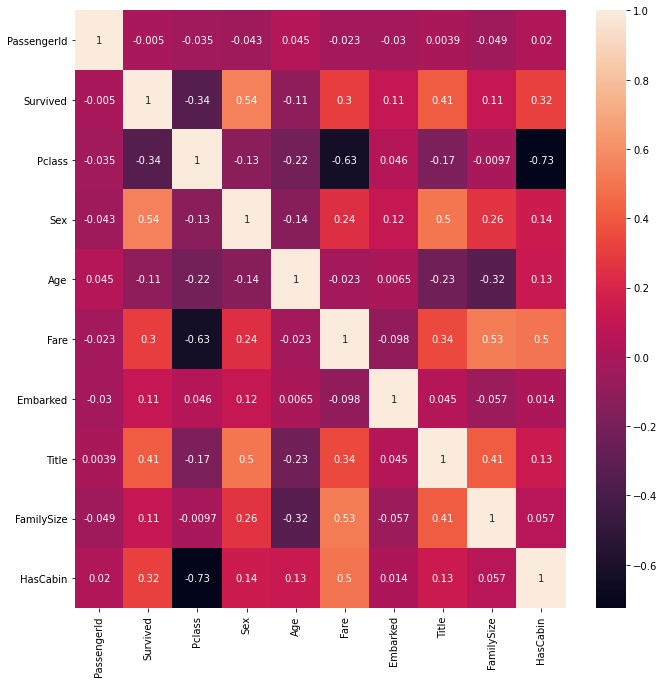

In [19]:
correlation = train.drop(columns=drop_features).corr()

plt.figure(figsize=(11, 11))
sns.heatmap(correlation, annot=True)
plt.show()

As can be seen, there is a (rather) strong correlation between "HasCabin" and "Pclass", because the values are close to -1. We drop one of them to remove redundancy.

The values of "HasCabin" are closer to 0 for different features, which means it is less correlated to other features rather than "Pclass"; so, we drop "Pclass".

In [20]:
drop_features.extend(['Pclass'])

train = train.drop(columns=drop_features)
test = test.drop(columns=drop_features)

X = train.drop(columns=['PassengerId', 'Survived'])
y = train['Survived']

X.head()

,Sex,Age,Fare,Embarked,Title,FamilySize,HasCabin
0,0,1,0,0,0,1,0
1,1,2,3,1,2,1,1
2,1,2,1,0,1,0,0
3,1,2,3,0,2,1,1
4,0,2,1,0,0,0,0


Now that the data cleaning, feature engineering, data encoding and feature selection is done, the dataset is up and ready to be fed to machine learning models.

# Classification
Here we apply different machine learning techniques to model the training data and later predicting who survived the shipwreck.

We don't have access to the actual survived values for the test data, since this the competition's rule, until competitors don't overfit the test data. Therefore, we split the training data into training and validation, and use validation data to evaluate our model. 

In [21]:
# Split training and validation data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, 
                                                  random_state=SEED)
X_test = test.drop(columns=['PassengerId']) # For consistency in naming variables

Now, we try different models, for which we use randomized search to optimize hyper-parameters based on prediction accuracy. The randomized search randomly samples from a grid of paramaters and performs K-fold cross validation with each combination of values.

In [22]:
# Cross-validator
from sklearn.model_selection import StratifiedKFold

cross_valid = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Define randomized search as a function for later use
def random_search(X, y, estimator, params, score="accuracy", cv=cross_valid, 
                  n_iter=100, random_state=SEED, n_jobs=-1):
    """
    Randomized search of parameters, using "cv" fold cross validation, search 
    across "n_iter" different combinations, and use all available cores
    """
    print("# Tuning hyper-parameters for {} by randomized search".format(score))
    
    classifier = RandomizedSearchCV(estimator=estimator, param_distributions=params, 
                             scoring=score, cv=cv, n_iter=n_iter, n_jobs=n_jobs, 
                             random_state=random_state)
    classifier.fit(X, y)
    
    print("Best parameters by random search:\n", classifier.best_params_)
    return classifier

## Random forest
Random forest is an ensemble learning method for classification that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean/average prediction of the individual trees [[link](https://en.wikipedia.org/wiki/Random_forest#:~:text=Random%20forests%20or%20random%20decision,average%20prediction%20(regression)%20of%20the)].

First, we define the model in the simplest form to see what the default parameters are.

The material is inspired by [Hyperparameter Tuning the Random Forest in Python](http://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [23]:
from sklearn.ensemble import RandomForestClassifier

# By setting random_state, we get the same result every time we run the command
random_forest = RandomForestClassifier(random_state=SEED)

random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [24]:
# Hyper-parameter tuning
# Note: running this cell takes a few minutes

# Create the parameter grid
# The keys are ordered alphabetically
params = {
    # Method of selecting samples for training each tree
    'bootstrap': [True, False],
    # Maximum number of levels in tree
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt'],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 5, 10],
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(200, 2000, num = 10)]
}

# Apply randomized search cross validation
random_forest_tuned = random_search(
    X_train, y_train, estimator=random_forest, params=params)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


### Learning curve


In [25]:
# Define a function to plot learning curve for later use
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot the test and training learning curves.
    """
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, scoring='accuracy', cv=cv, n_jobs=n_jobs, 
                       train_sizes=train_sizes, return_times=True)
    
    # Plot learning curve
    fig, ax = plt.subplots()
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", 
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.grid()
    plt.legend(loc="best")
    if ylim is not None:
        plt.ylim(*ylim)
    ax.set(title="Learning curves", 
           xlabel="Training examples", ylabel="Score")
 
    return plt

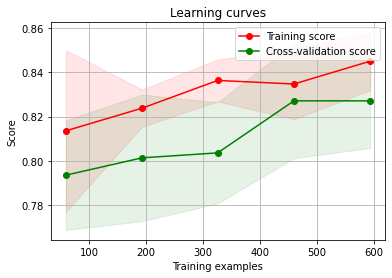

In [26]:
plot_learning_curve(random_forest_tuned.best_estimator_, 
                    X, y, cv=cross_valid)
plt.show()

Now that the best parameters are found, the model can be tested on validation data.

In [27]:
# Prediction on validation data
y_pred = random_forest_tuned.predict(X_val)

# Accuracy of prediction
accuracy_random_forest = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_random_forest)

Accuracy: 0.7713004484304933


## Support vector machine (SVM)
A support vector machine is a supervised machine learning model that uses classification algorithms for two-group classification problems.

In [28]:
# Default params of an svm
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=SEED)

svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 7,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [29]:
# Hyper-parameter tuning
params = {
    'C': scipy.stats.expon(scale=78),
    'class_weight':['balanced', None],
    'gamma': scipy.stats.expon(scale=.1),
    'kernel':['rbf', 'linear']
}

svc_tuned = random_search(X_train, y_train, estimator=svc, params=params)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'C': 114.17739728690962, 'class_weight': None, 'gamma': 0.019793508758675773, 'kernel': 'rbf'}


In [30]:
# Prediction on vlaidation data
y_pred = svc_tuned.predict(X_val)

# Accuracy
accuracy_svc = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_svc)

Accuracy: 0.7713004484304933


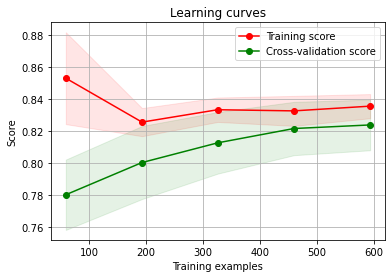

In [31]:
plot_learning_curve(svc_tuned.best_estimator_, X, y, cv=cross_valid)
plt.show()

## XGBoost
XGBoost is an open-source software library that provides a gradient boosting framework.

In [32]:
# Default params of an svm
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=SEED, verbosity=0)

xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 7,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0}

In [33]:
# Hyper-parameter tuning
params = {
    'colsample_bytree': list(np.arange(0.6, 1.0, step=0.05)),
    'gamma': list(np.arange(0.1, 15, step=0.2)),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.21],
    'max_depth': list(range(2, 12)),
    'min_child_weight': list(range(1, 12)),
    'n_estimators': [10, 100, 500, 1000],
    'reg_alpha': [10**i for i in range(-5, 1)],
    'subsample': list(np.arange(0.6, 1.0, step=0.05))
}

xgb_tuned = random_search(X_train, y_train, estimator=xgb, params=params)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'subsample': 0.9500000000000003, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.21, 'gamma': 4.9, 'colsample_bytree': 0.65}


In [34]:
# Prediction on vlaidation data
y_pred = xgb_tuned.predict(X_val)

# Accuracy
accuracy_xgboost = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_xgboost)

Accuracy: 0.7757847533632287


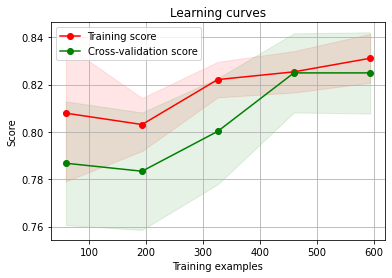

In [35]:
plot_learning_curve(xgb_tuned.best_estimator_, X, y, cv=cross_valid)
plt.show()

## Decision Tree
A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes) [[link](https://en.wikipedia.org/wiki/Decision_tree#:~:text=A%20decision%20tree%20is%20a%20flowchart%2Dlike%20structure%20in%20which,taken%20after%20computing%20all%20attributes)].

In [36]:
# Default params of an svm
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=SEED)

decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 7,
 'splitter': 'best'}

In [37]:
# Hyper-parameter tuning
params = {
    'criterion': ["gini", "entropy"],
    'max_depth': list(range(1, 32)),
    'max_features': list(range(1, X_train.shape[1]+1)),
    'min_samples_leaf': list(range(1, 9)),
    'min_samples_split': list(np.arange(0.1, 1.1, step=0.1))
}

decision_tree_tuned = random_search(
    X_train, y_train, estimator=decision_tree, params=params)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'min_samples_split': 0.1, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': 25, 'criterion': 'gini'}


In [38]:
# Prediction on vlaidation data
y_pred = decision_tree_tuned.predict(X_val)

# Accuracy
accuracy_decision_tree = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_decision_tree)

Accuracy: 0.7623318385650224


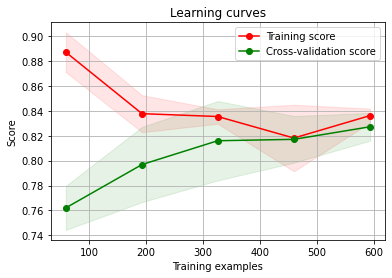

In [39]:
plot_learning_curve(decision_tree_tuned.best_estimator_, X, y, cv=cross_valid)
plt.show()

## K-Nearest Neighbors
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used that assumes similar things exist in close proximity.

In [40]:
# Default params
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [41]:
# Hyper-parameter tuning
# Note: running this cell takes a few minutes
params = {
    'leaf_size': list(range(20, 60)),
    'n_neighbors': list(range(3, 30)),
    'p': [1, 2]
}

knn_tuned = random_search(X_train, y_train, estimator=knn, params=params)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'p': 1, 'n_neighbors': 18, 'leaf_size': 25}


In [42]:
# Prediction on vlaidation data
y_pred = knn_tuned.predict(X_val)

# Accuracy
accuracy_knn = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_knn)

Accuracy: 0.7174887892376681


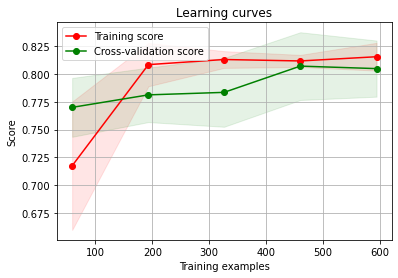

In [43]:
plot_learning_curve(knn_tuned.best_estimator_, X, y, cv=cross_valid)
plt.show()

## Logistic regression
The logistic model is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc [[link](https://en.wikipedia.org/wiki/Logistic_regression)].

The material is borrowed from [here](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

In [44]:
# Default params
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(random_state=SEED)

logistic_regression.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 7,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [45]:
# Hyper-parameter tuning
params = {
    'C': scipy.stats.loguniform(1e-4, 100),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

logistic_regression_tuned = random_search(
    X_train, y_train, estimator=logistic_regression, params=params)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'C': 0.4011377228340273, 'penalty': 'l1', 'solver': 'liblinear'}


In [46]:
# Prediction on vlaidation data
y_pred = logistic_regression_tuned.predict(X_val)

# Accuracy
accuracy_logistic_regression = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_logistic_regression)

Accuracy: 0.757847533632287


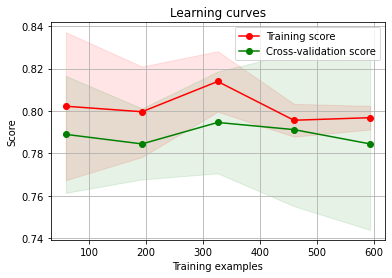

In [47]:
plot_learning_curve(logistic_regression_tuned.best_estimator_, 
                    X, y, cv=cross_valid)
plt.show()

## Naive Bayes
Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features [[link](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)].

In [48]:
# Default params
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

naive_bayes.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [49]:
# Hyper-parameter tuning
params = {
    'var_smoothing': [np.exp(-i) for i in range(1, 15)]
}

naive_bayes_tuned = random_search(
    X_train, y_train, estimator=naive_bayes, params=params, n_iter=15-1)

# Tuning hyper-parameters for accuracy by randomized search
Best parameters by random search:
 {'var_smoothing': 0.049787068367863944}


In [50]:
# Prediction on vlaidation data
y_pred = naive_bayes_tuned.predict(X_val)

# Accuracy
accuracy_naive_bayes = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_naive_bayes)

Accuracy: 0.7533632286995515


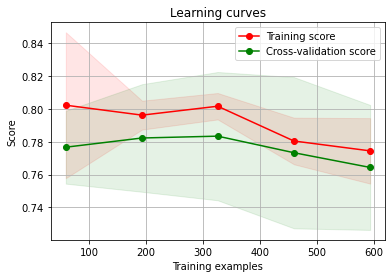

In [51]:
plot_learning_curve(naive_bayes_tuned.best_estimator_, 
                    X, y, cv=cross_valid)
plt.show()

## Conclusion
The following is the result of running different models on the Titanic dataset.

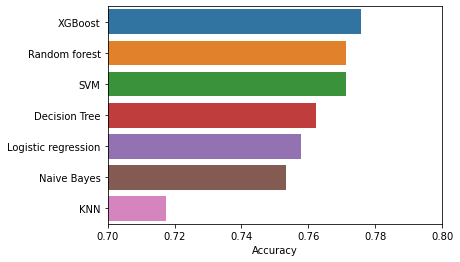

In [52]:
accuracy_df = pd.DataFrame({
    'Model': ['Random forest', 'SVM', 'XGBoost', 'Decision Tree', 'KNN', 
              'Logistic regression', 'Naive Bayes'],
    'Accuracy': [accuracy_random_forest, accuracy_svc, accuracy_xgboost,
                 accuracy_decision_tree, accuracy_knn,
                 accuracy_logistic_regression, accuracy_naive_bayes]
})

# Sort
accuracy_df_sorted = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Plot
g = sns.barplot(data=accuracy_df_sorted, y='Model', x='Accuracy')
g.set(ylabel='', xlim=(0.7, 0.8))
plt.show()